# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
from tqdm.contrib.itertools import product
from tqdm.autonotebook import tqdm
import copy

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing
INFO:root:returning grid with new region and/or registration, same spacing


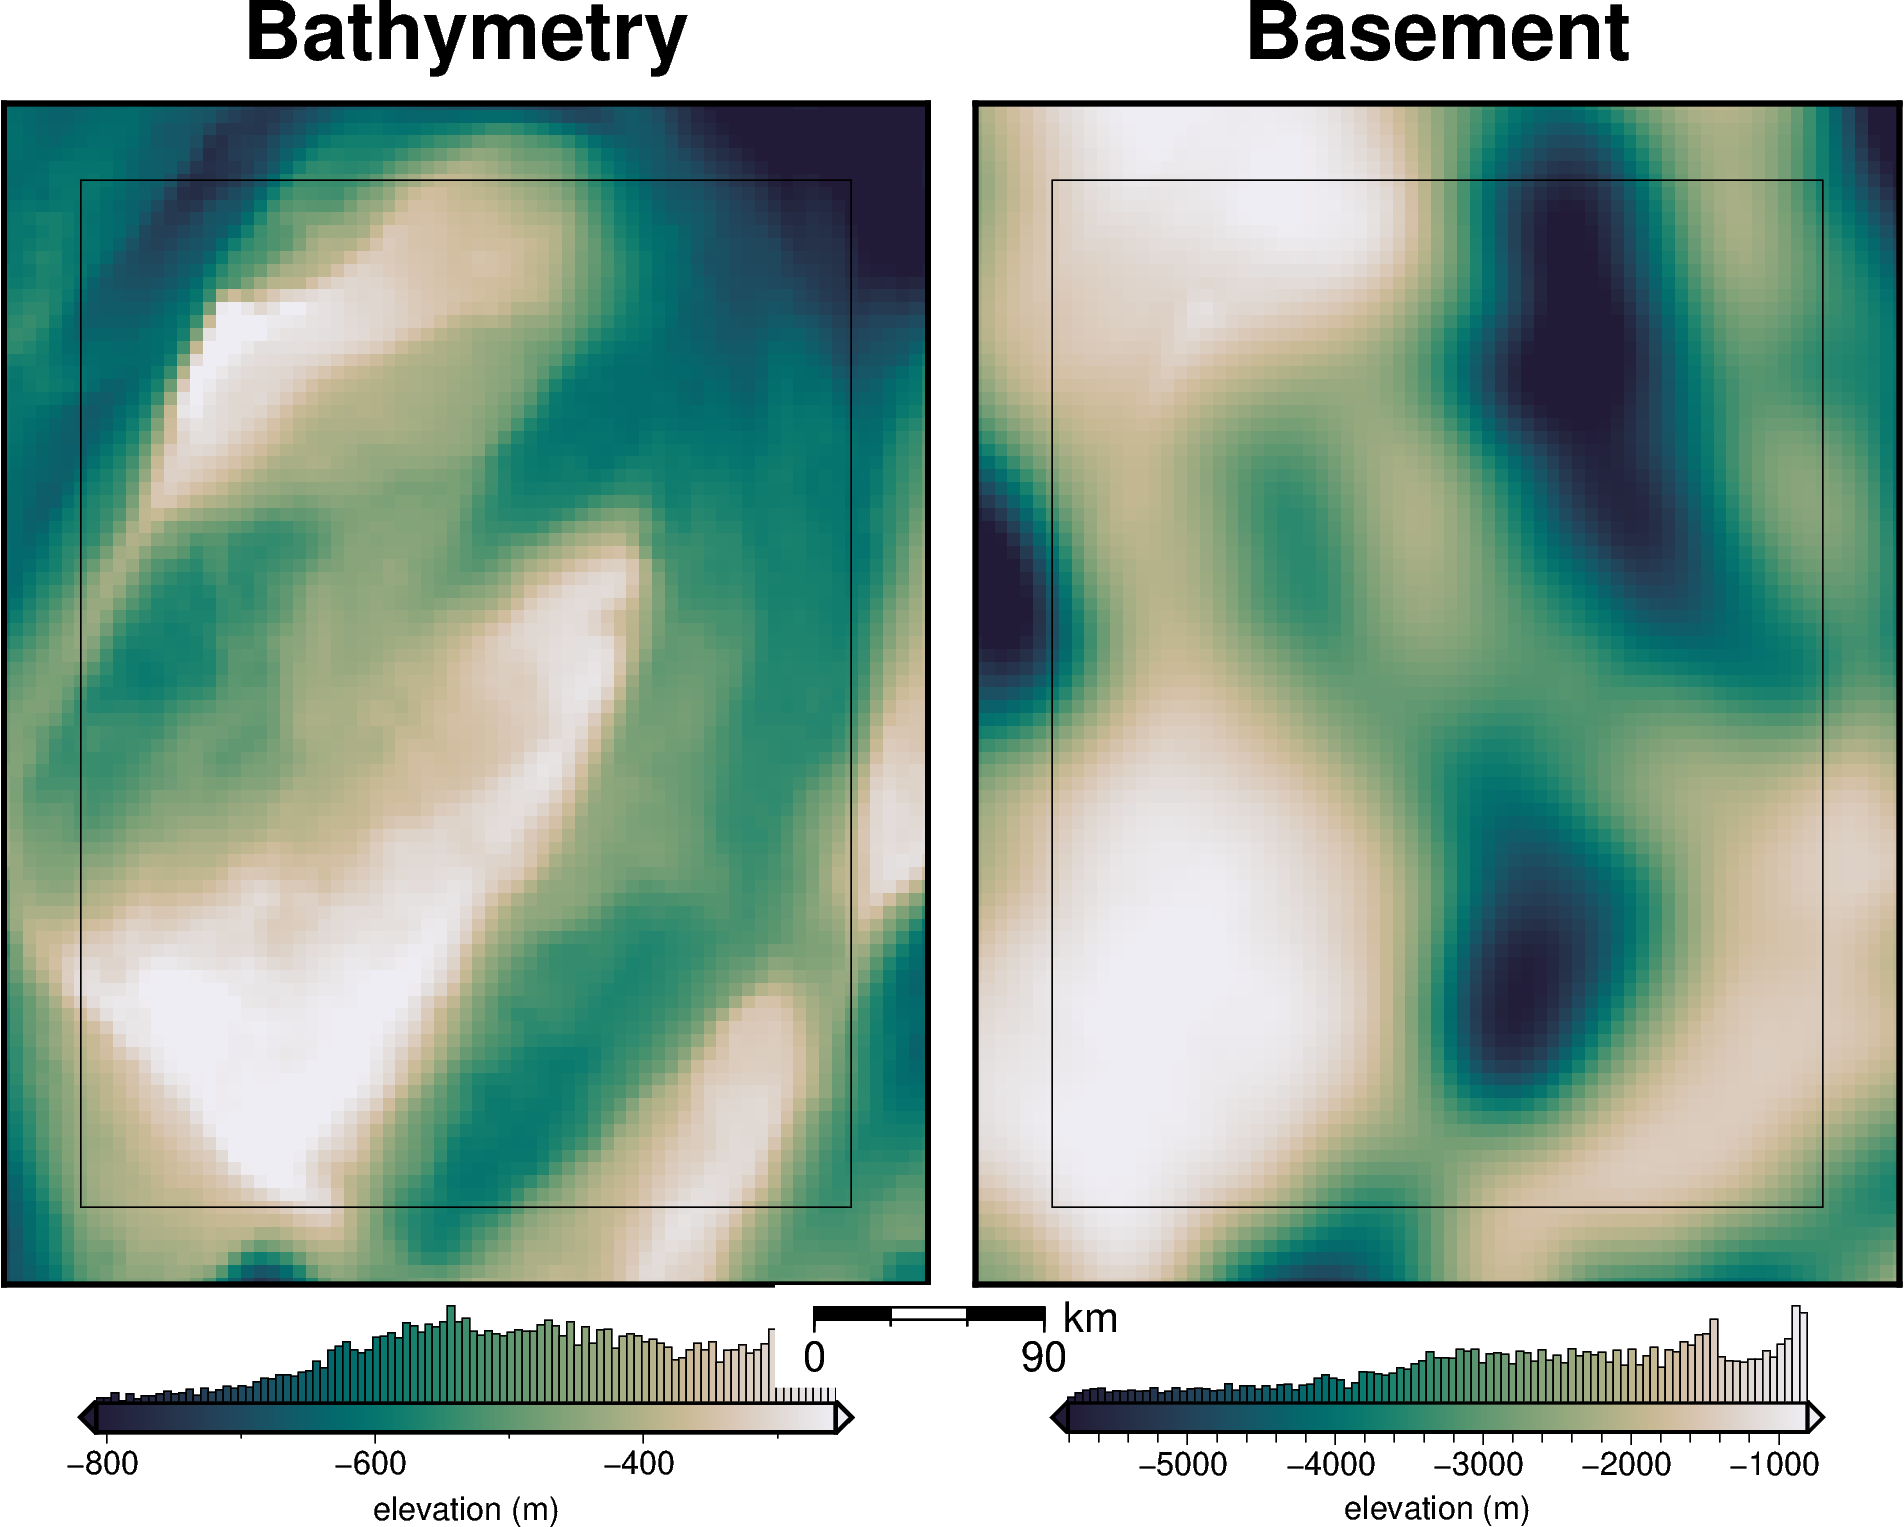

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

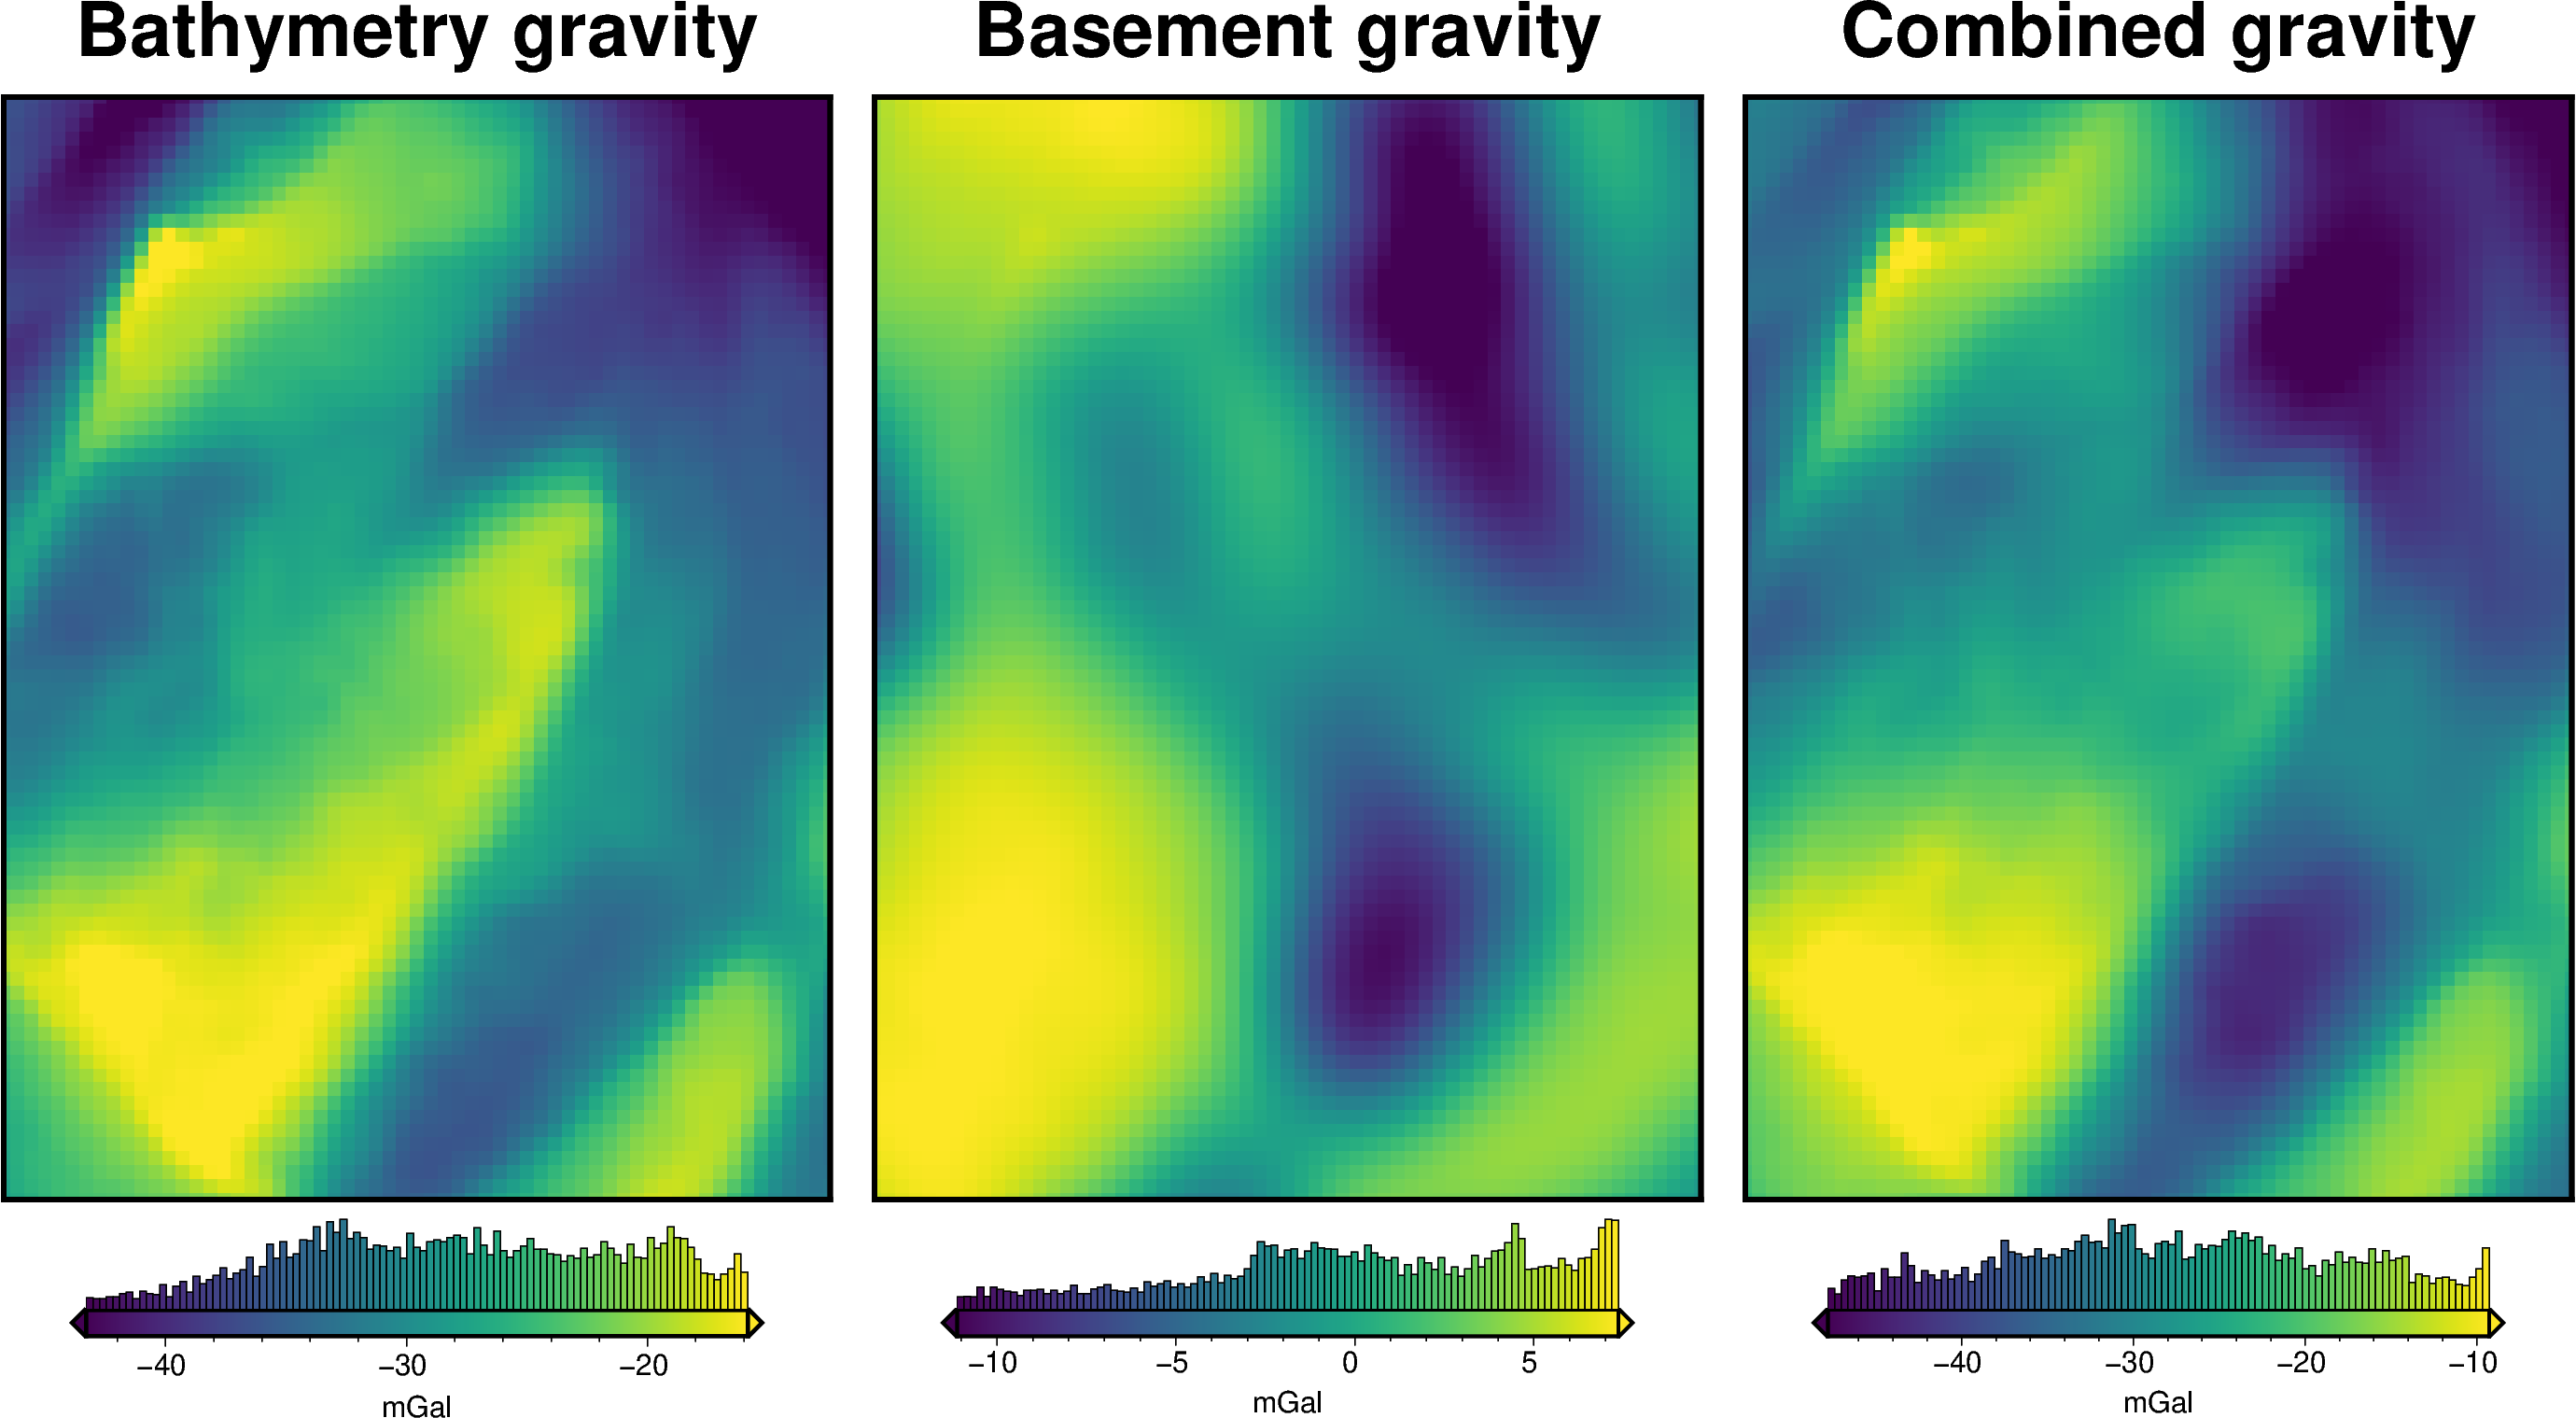

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    basement=True,
    gravity_noise=0,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

# normalize regional gravity between 0 and 1
grav_df["basement_grav_normalized"] = vd.grid_to_table(utils.normalize_xarray(
    grav_df.set_index(["northing", "easting"]).to_xarray().basement_grav,
    low=-1,
    high=1,
)).reset_index().basement_grav

In [3]:
grav_df.describe()

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly,basement_grav_normalized
count,4.941000e+03,4941.00000,4941.0,4941.000000,4.941000e+03,4941.000000,4941.0,4941.000000,4941.000000
mean,-1.600000e+06,110000.00000,1000.0,-28.076339,-1.104426e-15,-28.076339,0.0,-28.076339,0.259171
std,1.169164e+05,88042.99419,0.0,7.267542,5.084792e+00,10.422159,0.0,10.422159,0.491861
min,-1.800000e+06,-40000.00000,1000.0,-50.834525,-1.301714e+01,-54.808150,0.0,-54.808150,-1.000000
25%,-1.700000e+06,35000.00000,1000.0,-33.380910,-3.033944e+00,-35.767154,0.0,-35.767154,-0.034308
50%,-1.600000e+06,110000.00000,1000.0,-28.037682,3.065578e-01,-28.122260,0.0,-28.122260,0.288825
75%,-1.500000e+06,185000.00000,1000.0,-21.983838,4.323170e+00,-20.221411,0.0,-20.221411,0.677359
max,-1.400000e+06,260000.00000,1000.0,-13.088736,7.658592e+00,-5.937589,0.0,-5.937589,1.000000


np.float64(2.459055268316614)

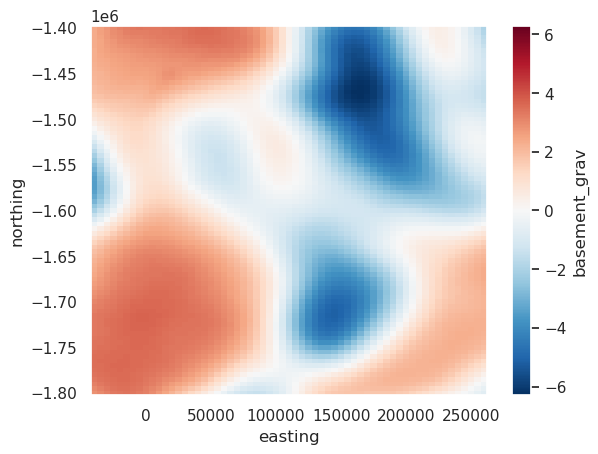

In [4]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

regional_grav = utils.normalize_xarray(
    grav_grid.basement_grav_normalized,
    low=0,
    high=10,
).rename("basement_grav")

regional_grav -= regional_grav.mean()

grav_df["basement_grav"] = vd.grid_to_table(regional_grav).reset_index().basement_grav

grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_grid.basement_grav.plot()
utils.rmse(grav_df.basement_grav)

# Run ensemble of inversions with varying constraint spacing and regional strength

In [5]:
# Define number of constraints on log scale
constraint_numbers = np.unique(np.round(np.geomspace(1,25,10)))
# constraint_numbers = np.linspace(1, 25**2, 10).astype(int)
constraint_numbers = [int(i) for i in constraint_numbers]
constraint_numbers.reverse()
# constraint_numbers = [constraint_numbers[0], constraint_numbers[4]]

constraint_numbers

[25, 17, 12, 9, 6, 4, 3, 2, 1]

In [7]:
regional_strengths = np.linspace(1, 50, 9)
regional_strengths

array([ 1.   ,  7.125, 13.25 , 19.375, 25.5  , 31.625, 37.75 , 43.875,
       50.   ])

In [8]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

In [10]:
grav_dfs = []
grav_grids = []
param_coords = []
starting_prism_layers = []
constraints_dfs = []
constraints_spacings = []
for i, (c, s) in enumerate(product(constraint_numbers, regional_strengths, desc="Constraint Spacing/Regional Strength")):
    param_coords.append([c, s])

    # make constraint points
    constraint_points = RIS_synth.constraint_layout_number(
        shape=(c, c),
        region=inversion_region,
        padding=-spacing,
    )

    # sample true topography at these points
    constraint_points = utils.sample_grids(
        constraint_points,
        bathymetry,
        "upward",
        coord_names=("easting", "northing"),
    )
    constraints_dfs.append(constraint_points)
    # grid the sampled values using verde
    starting_bathymetry = utils.create_topography(
        method="splines",
        region=buffer_region,
        spacing=spacing,
        constraints_df=constraint_points,
        dampings=None,
    )

    x_spacing=(inversion_region[1]-inversion_region[0])/c
    y_spacing=(inversion_region[3]-inversion_region[2])/c
    constraint_spacing = (x_spacing + y_spacing)/2
    constraints_spacings.append(constraint_spacing)

    density_grid = xr.where(
        starting_bathymetry >=  zref,
        density_contrast,
        -density_contrast,
    )

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_bathymetry,
        zref,
        density=density_grid,
    )
    starting_prism_layers.append(starting_prisms)

    # copy gravity dataframe
    df = copy.deepcopy(grav_df)

    df["starting_gravity"] = starting_prisms.prism_layer.gravity(
        coordinates=(
            df.easting,
            df.northing,
            df.upward,
        ),
        field="g_z",
        progressbar=False,
    )

    # calculate the true residual misfit
    df["true_res"] = df.bathymetry_grav -df.starting_gravity

    # re-scale the regional gravity
    regional_grav = utils.normalize_xarray(
        grav_grid.basement_grav_normalized,
        low=0,
        high=s,
    ).rename("basement_grav")

    regional_grav -= regional_grav.mean()

    df["basement_grav"] = vd.grid_to_table(regional_grav).reset_index().basement_grav

    df["gravity_anomaly"] = df.bathymetry_grav + df.basement_grav

    # estimate regional
    df = regional.regional_separation(
        grav_df=df,
        method="constraints",
        grid_method="eq_sources",
        constraints_df=constraint_points,
        damping=None,
        depth="default",
        block_size=None,
    )

    grav_dfs.append(df)

    grav_grid = df.set_index(["northing", "easting"]).to_xarray()
    grav_grids.append(grav_grid)


Constraint Spacing/Regional Strength:   0%|          | 0/81 [00:00<?, ?it/s]

ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.
ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.


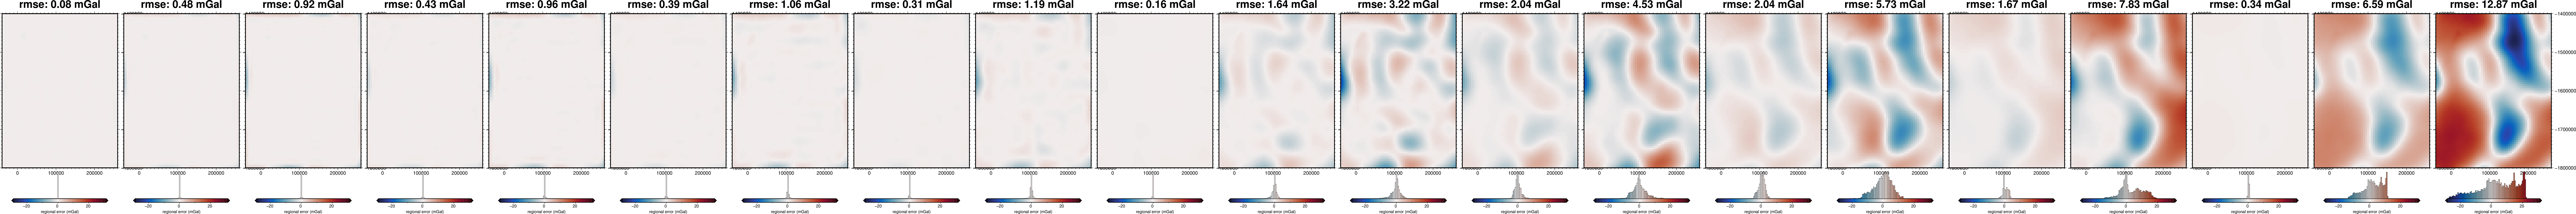

In [11]:
cpt_lims = polar_utils.get_combined_min_max(
    [g.basement_grav - g.reg for g in grav_grids],
)
rmses = []
for i, g in enumerate(grav_grids):
    if i == 0:
        fig = None
        origin_shift="initialize"
    else:
        origin_shift="xshift"

    if i % 4 == 0:
        dif = (g.basement_grav - g.reg)
        fig = maps.plot_grd(
            # grav_grid.res,
            dif,
            region=inversion_region,
            fig_height=10,
            fig=fig,
            origin_shift=origin_shift,
            title=f"rmse: {round(utils.rmse(dif),2)} mGal",
            cmap="balance+h0",
            cpt_lims=cpt_lims,
            hist=True,
            cbar_label="regional error (mGal)",
            frame=["nSwE", "xaf10000", "yaf10000"],
        )
    rmses.append(utils.rmse(dif))

fig.show()

<Axes: >

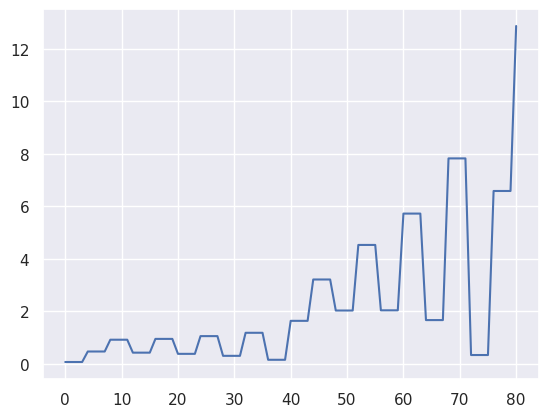

In [12]:
pd.Series(rmses).plot()

<Axes: >

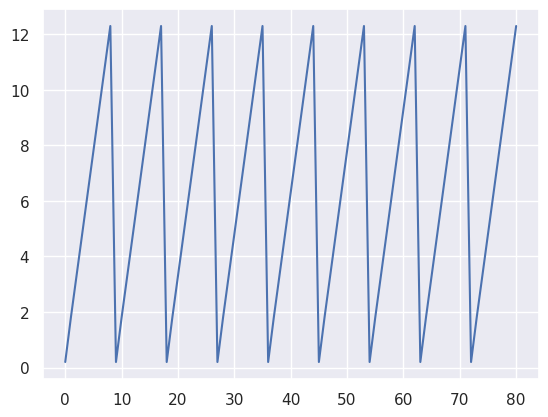

In [91]:
regional_rmses = [round(utils.rmse(g.basement_grav),1) for g in grav_dfs]
pd.Series(regional_rmses).plot()

In [14]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .01**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

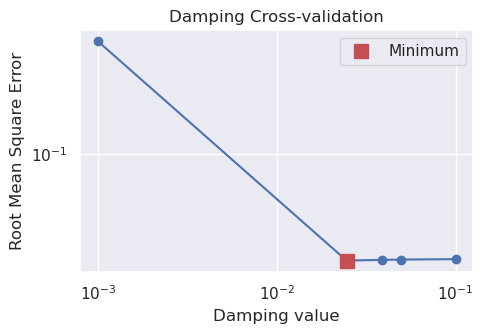

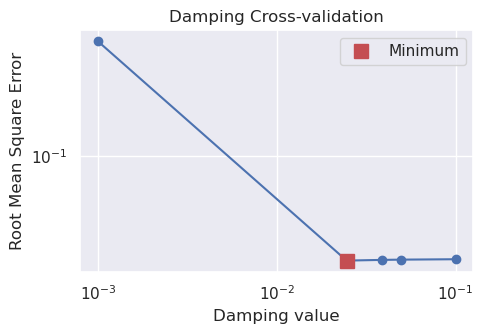

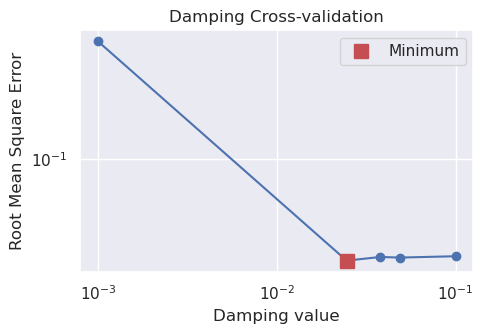

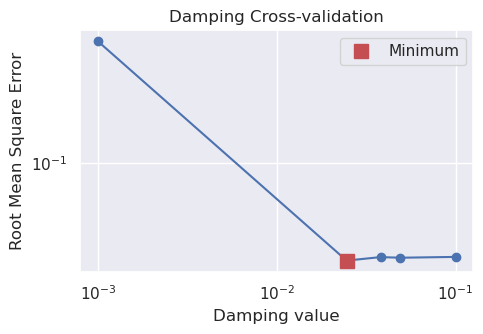

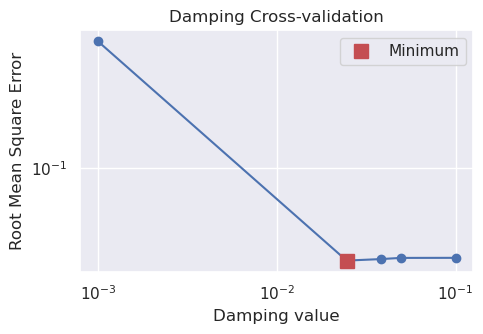

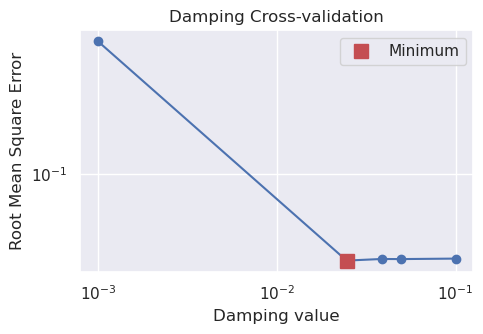

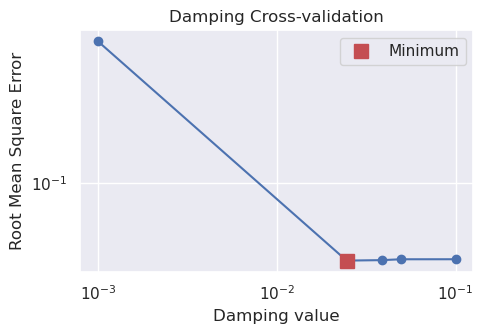

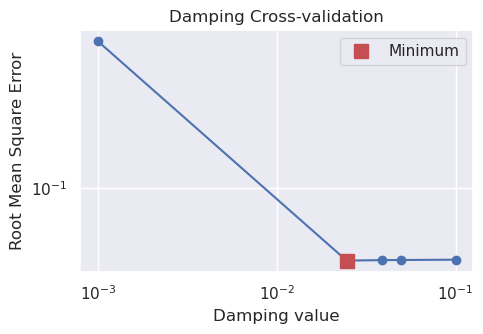

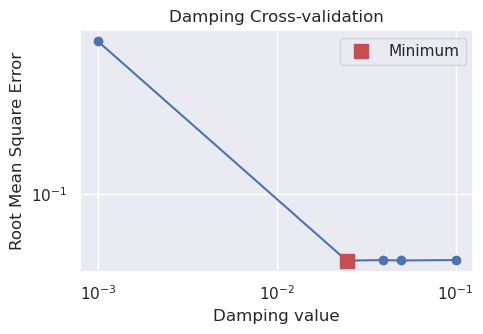

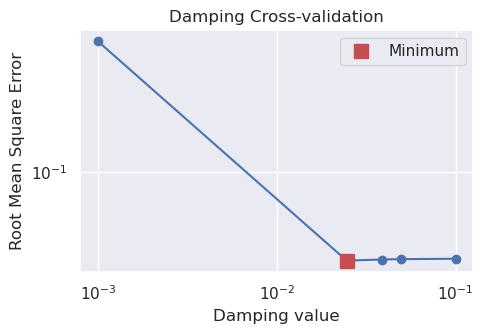

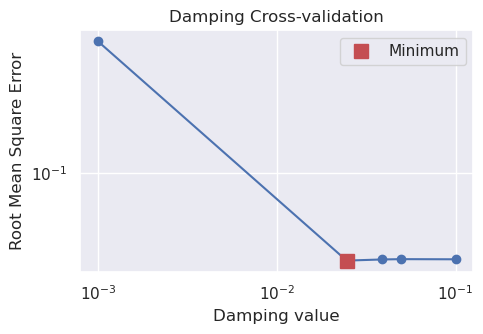

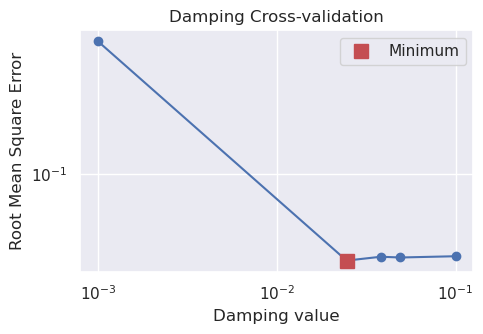

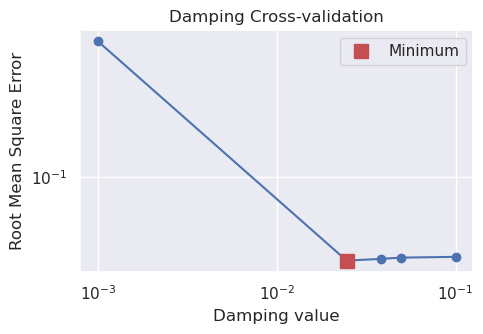

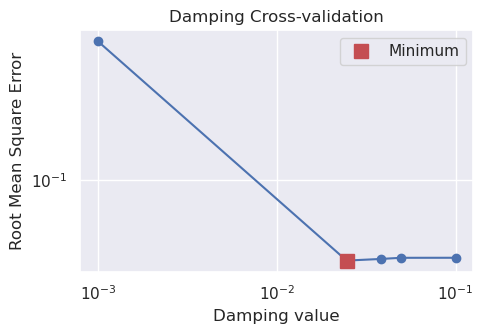

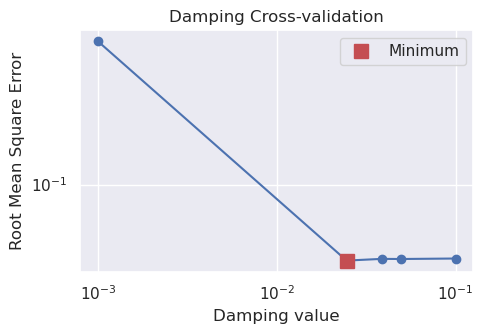

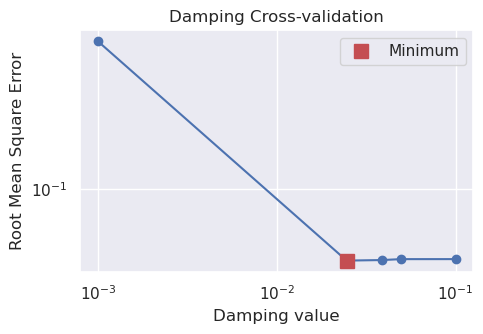

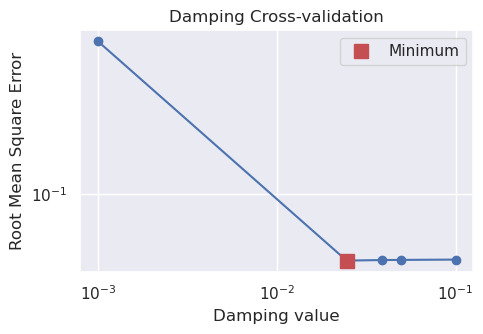

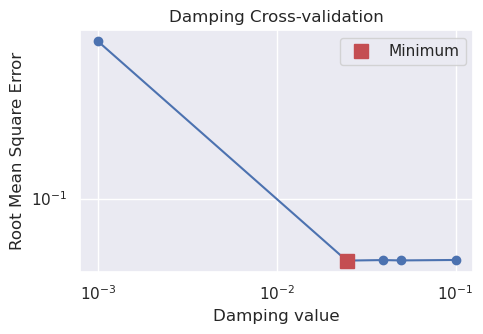

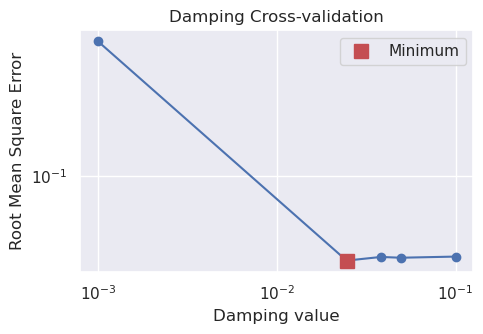

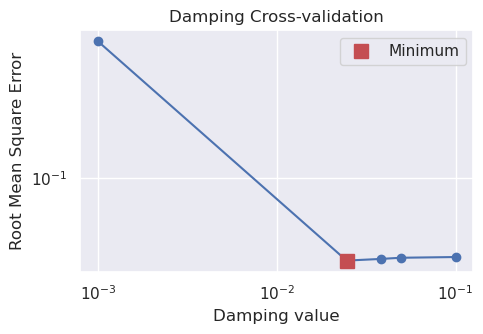

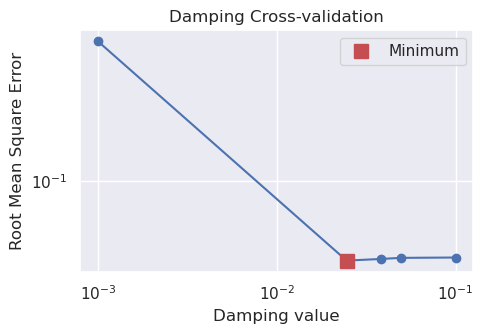

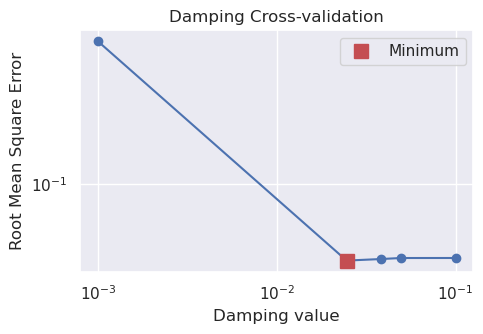

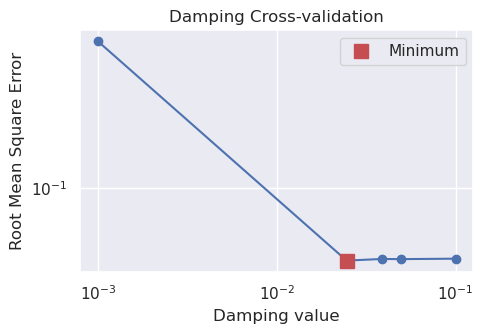

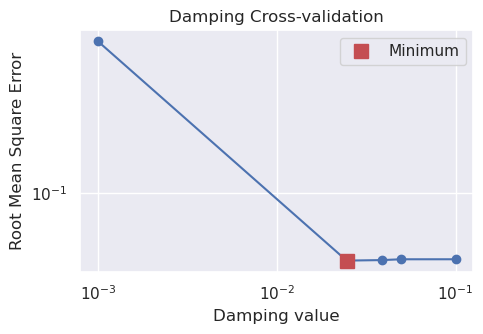

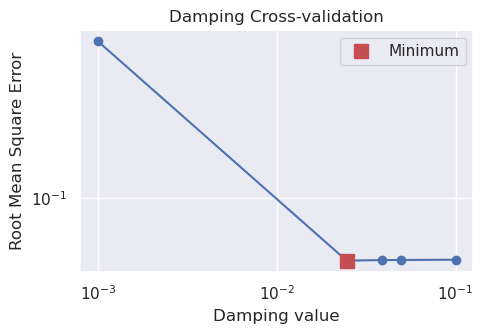

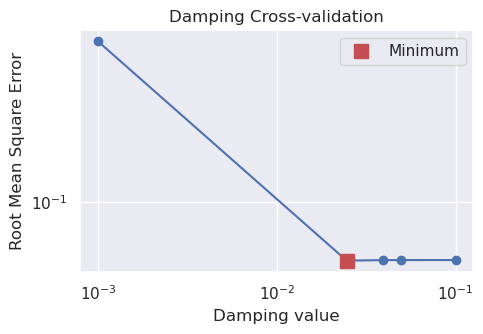

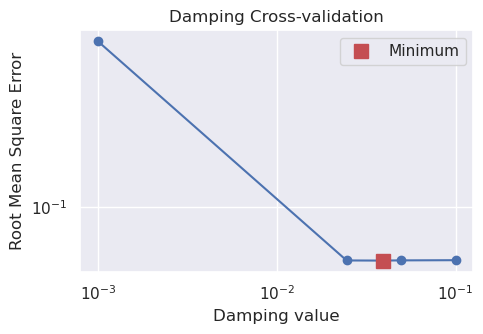

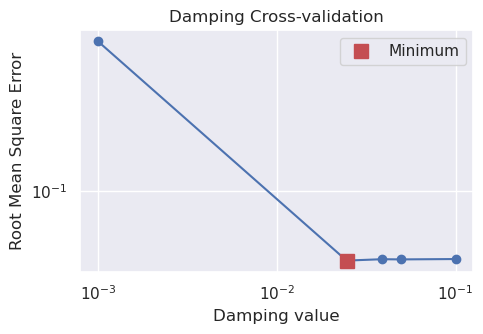

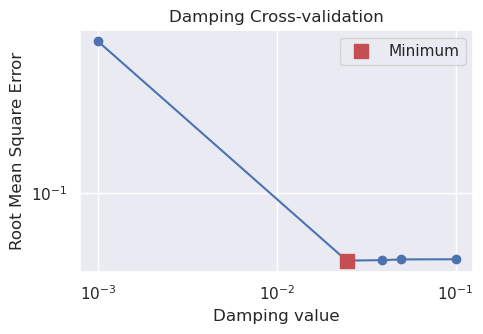

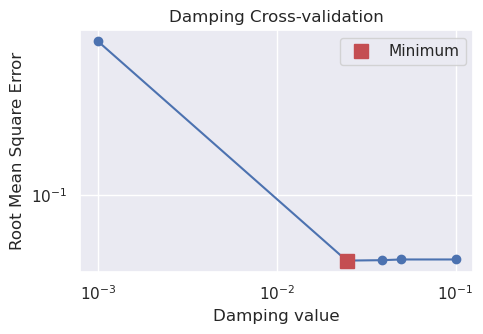

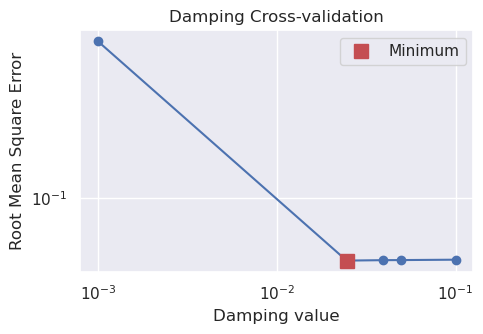

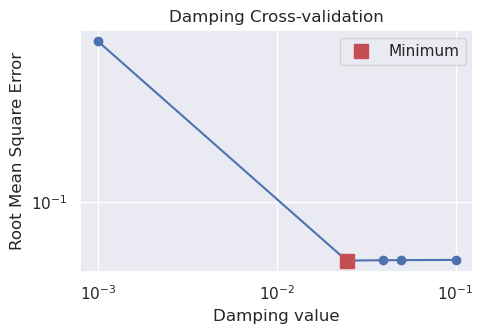

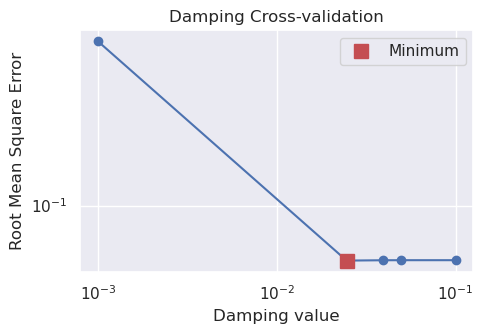

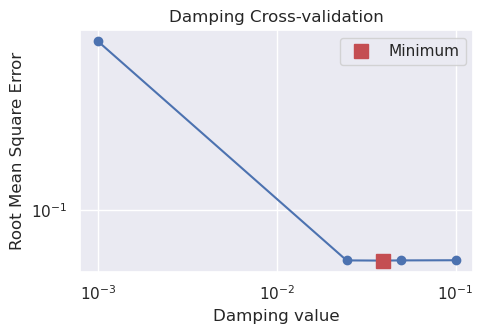

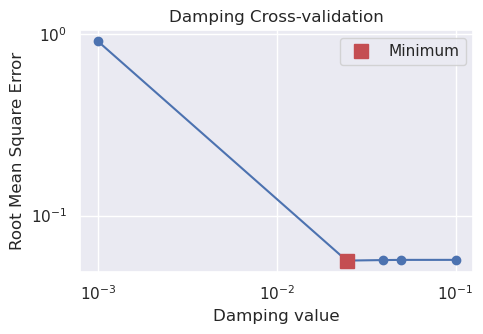

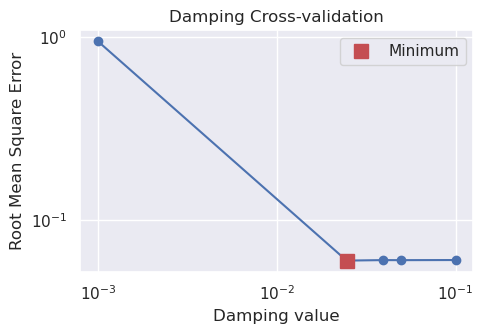

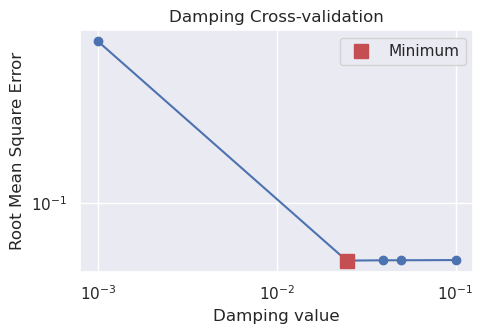

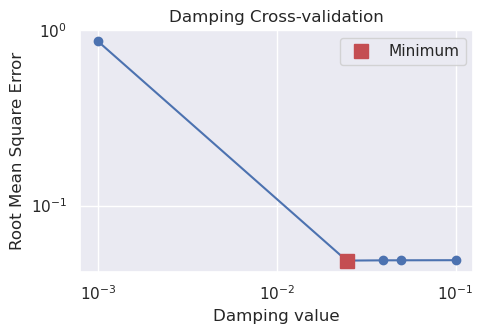

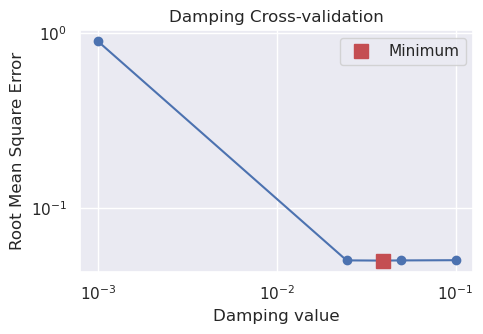

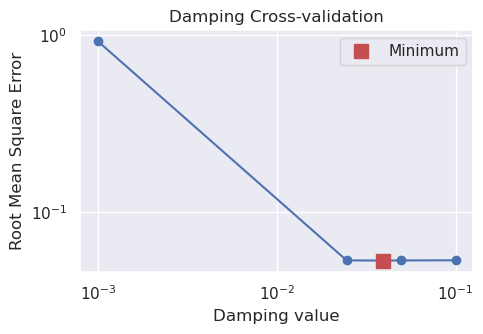

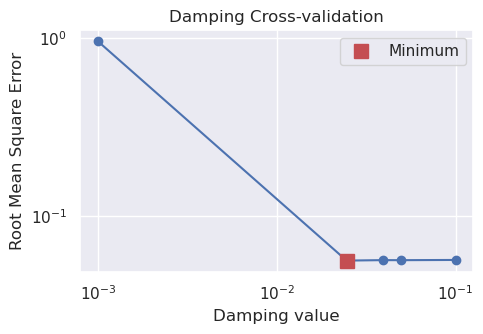

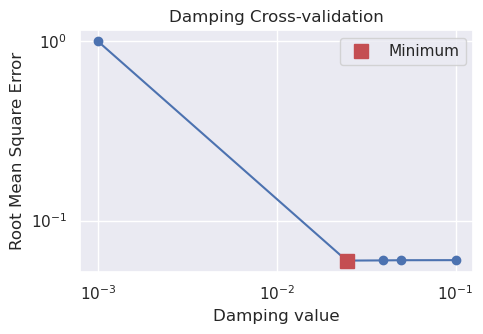

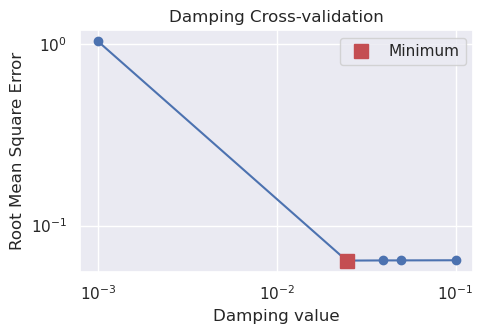

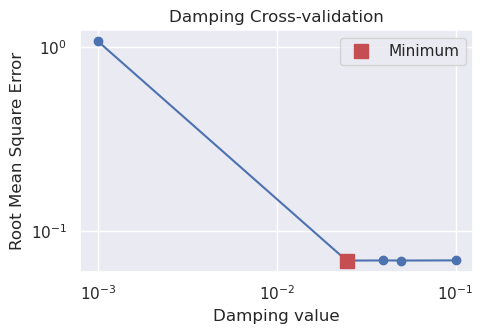

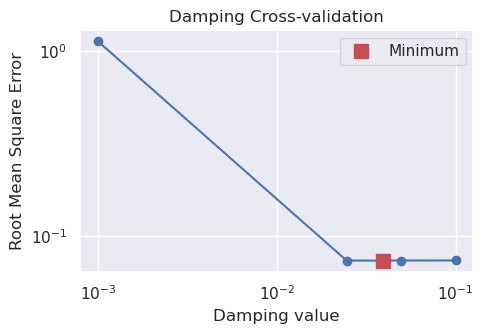

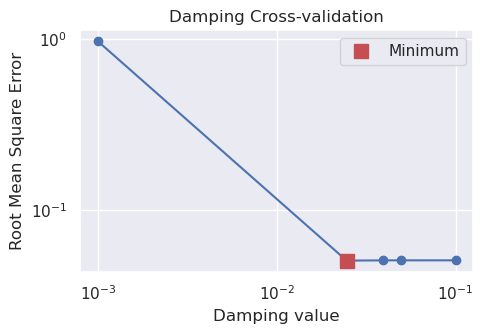

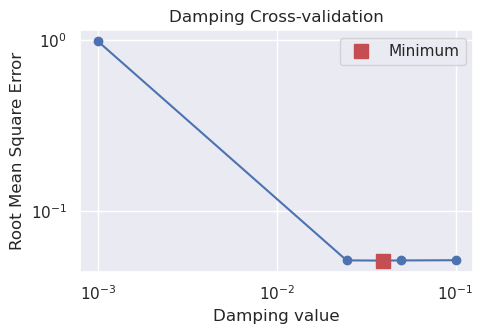

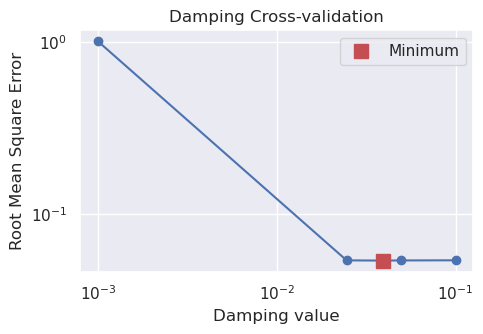

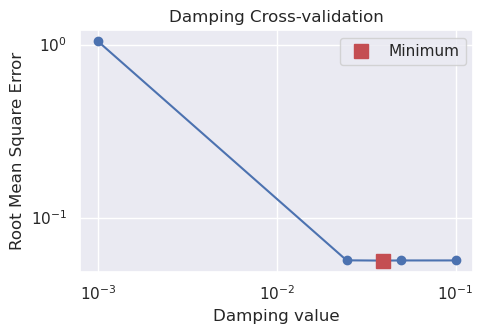

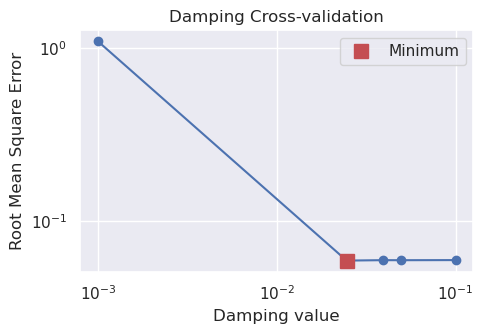

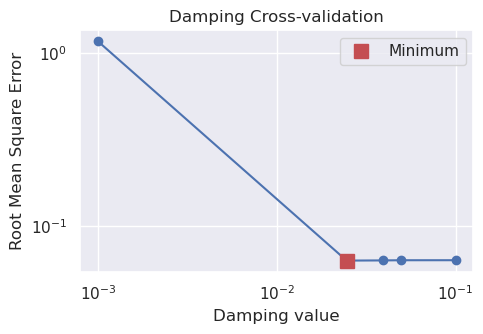

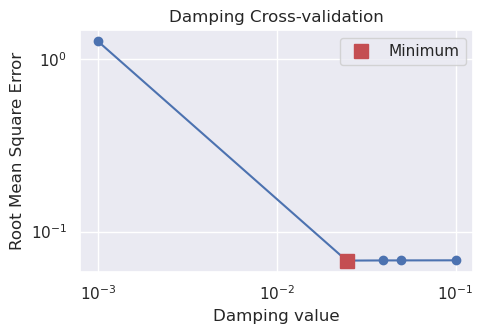

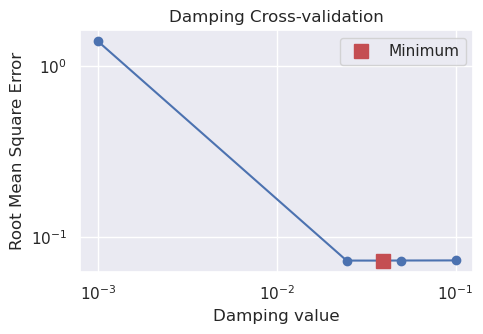

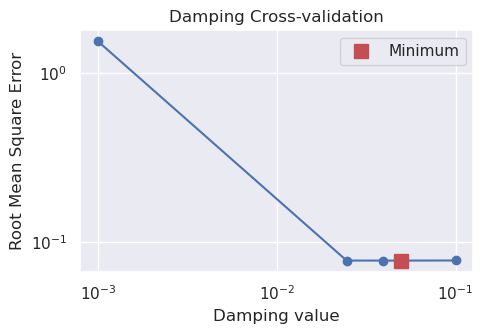

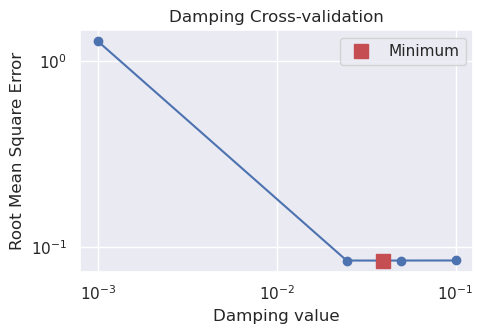

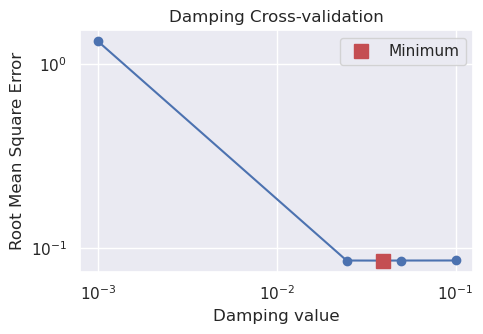

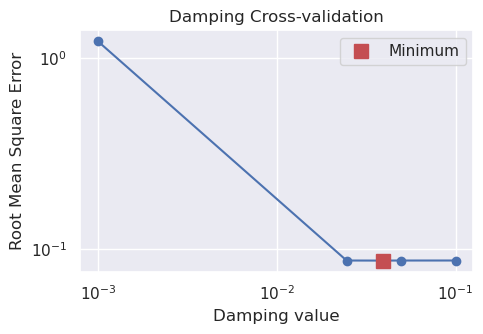

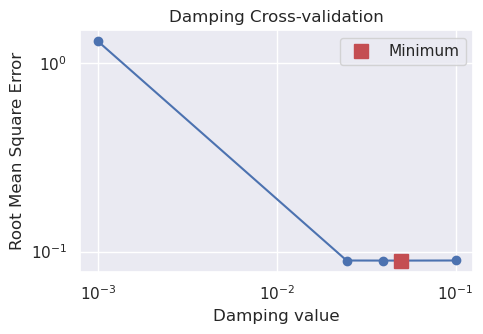

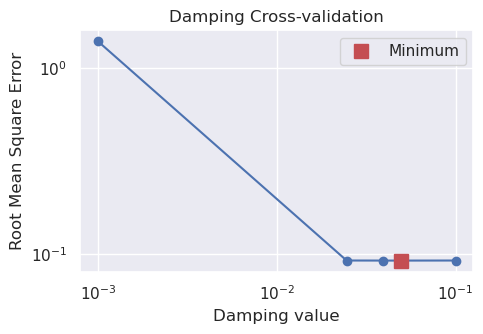

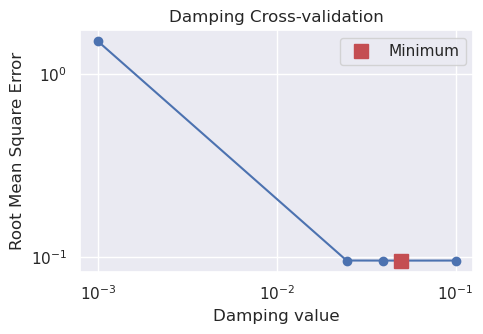

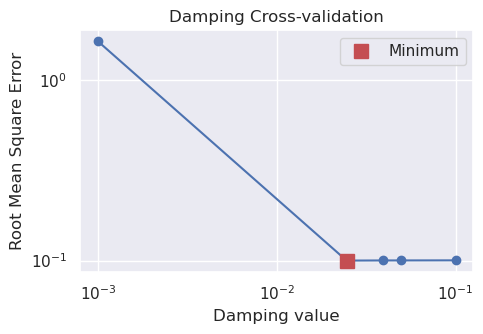

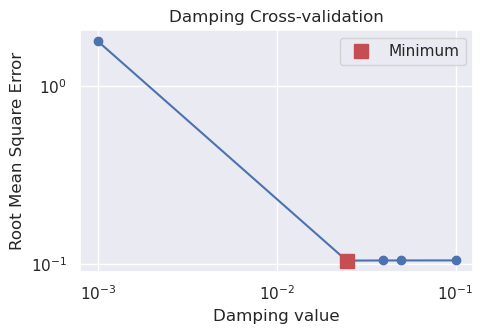

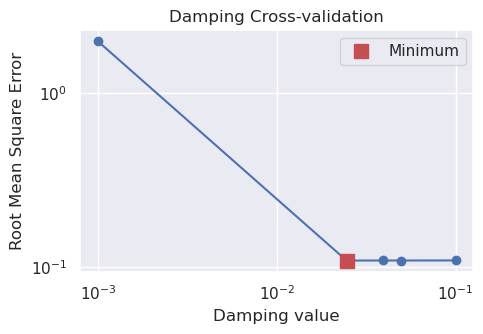

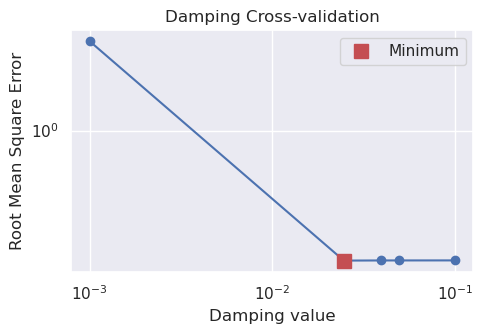

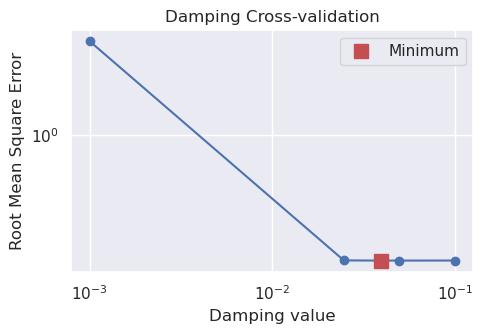

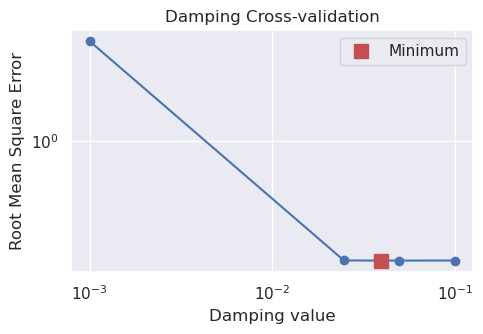

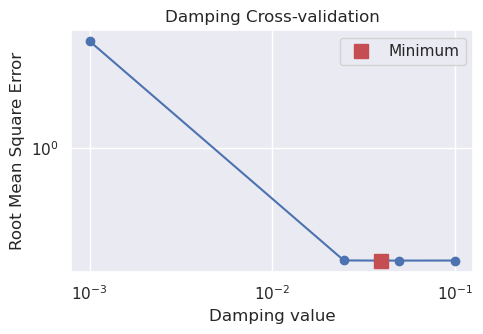

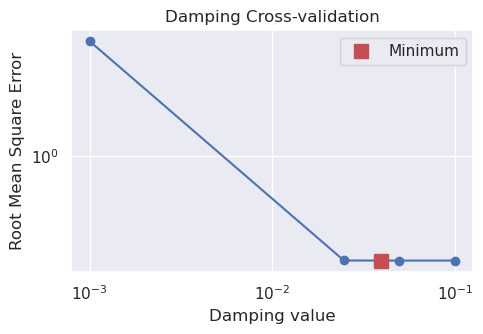

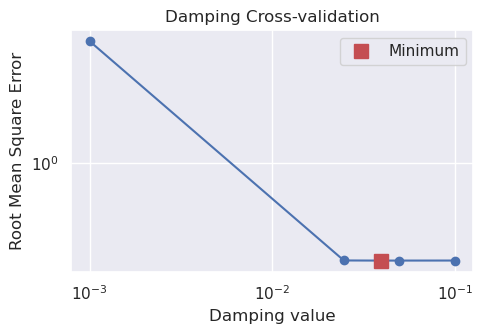

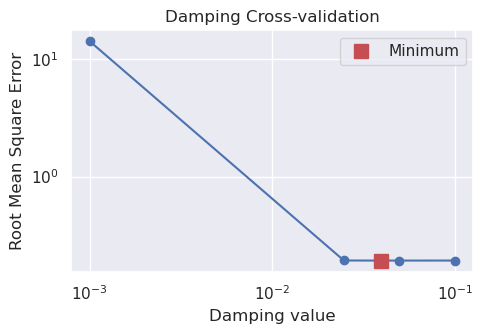

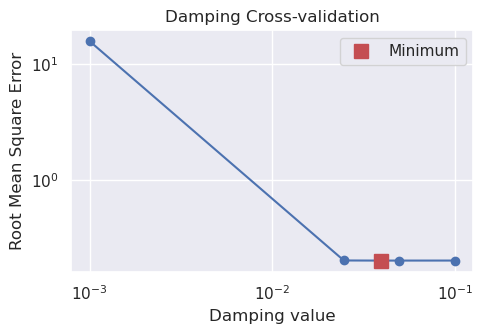

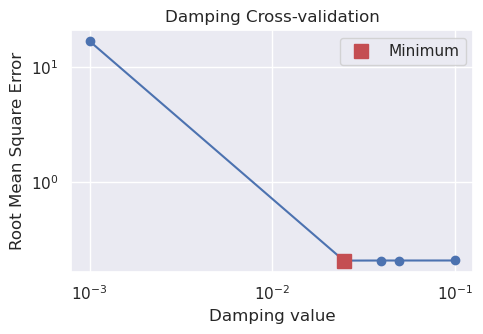

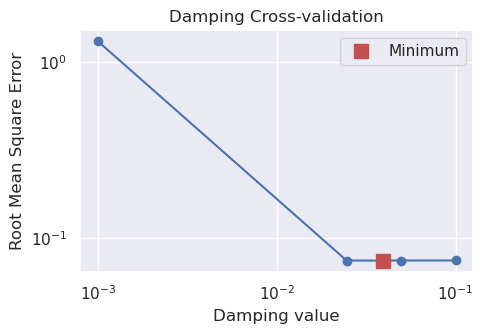

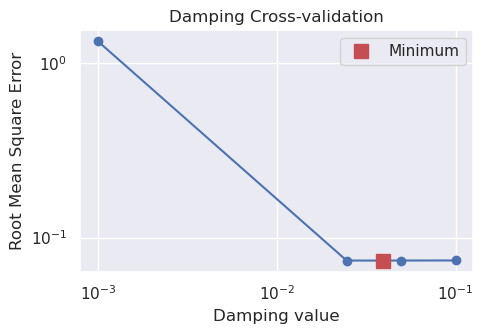

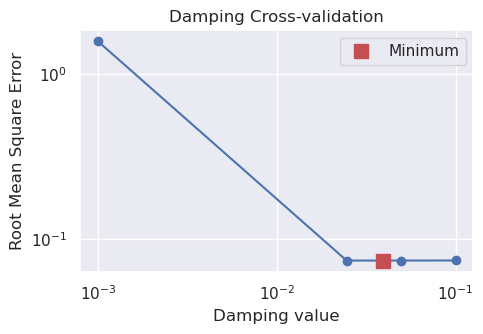

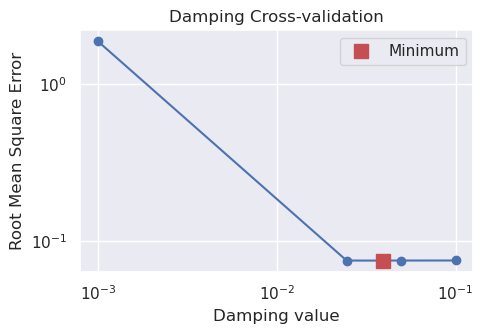

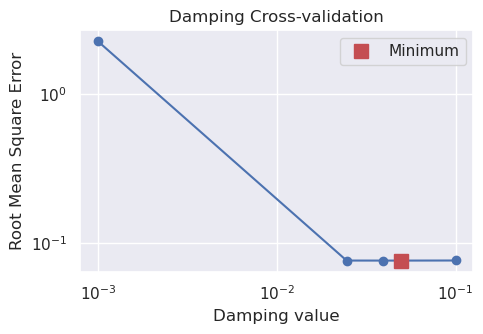

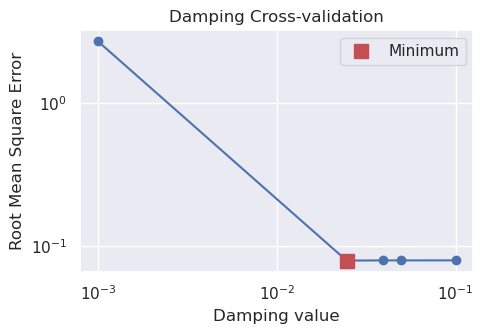

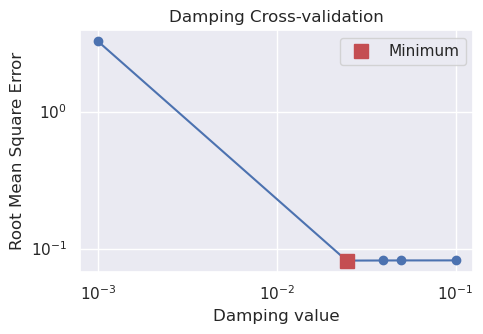

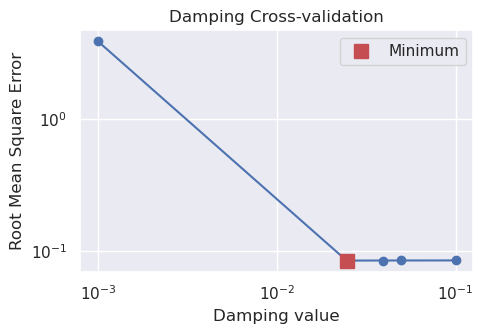

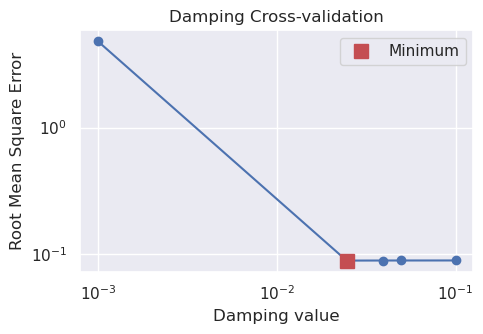

In [15]:
logging.getLogger().setLevel(logging.WARN)

for i, df in enumerate(tqdm(grav_dfs)):
    # run the inversion workflow, including a cross validation for the damping parameter
    inversion.run_inversion_workflow(
        grav_df=df,
        starting_prisms=starting_prism_layers[i],
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        # solver_damping=0.02,
        run_damping_cv=True,
        damping_limits=(0.001, 0.1),
        damping_cv_trials=5,
        plot_cv=True,
        fname=f"../../results/Ross_Sea_10_damping_cv_constraint_spacing_regional_strength_{param_coords[i]}",
        **kwargs,
    )


In [180]:
scores = []
rmses = []
dampings = []
starting_topo_rmses = []
for i, p in enumerate(param_coords):
    fname=f"../../results/Ross_Sea_10_damping_cv_constraint_spacing_regional_strength_{p}"

    with pathlib.Path(f"{fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    with pathlib.Path(f"{fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)
    dampings.append(study.best_params["damping"])
    scores.append(study.best_value)

    final_topo = results[0].set_index(["northing", "easting"]).to_xarray().topo
    inside_final_topo = final_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_bathy = bathymetry.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    rmse = utils.rmse(inside_final_topo-inside_bathy)
    rmses.append(rmse)

    # compare starting and actual bathymetry grids
    grids = polar_utils.grd_compare(
        bathymetry,
        starting_prism_layers[i].bottom,
        region=inversion_region,
    )
    starting_topo_rmses.append(utils.rmse(grids[0]))

ensemble_df = pd.DataFrame(
    {
        "constraint_numbers": [p[0] for p in param_coords],
        "regional_strength": [p[1] for p in param_coords],
        "regional_rmse": regional_rmses,
        "score": scores,
        "rmse": rmses,
        "dampings": dampings,
        "starting_topo_rmse": starting_topo_rmses,
        "num_constraints": [len(c) for c in constraints_dfs],
    }
)

inversion_area = (inversion_region[1]-inversion_region[0])/1000*(inversion_region[3]-inversion_region[2])/1000000

ensemble_df["topo_improvement"] = ensemble_df.starting_topo_rmse - ensemble_df.rmse
# ensemble_df["topo_improvement"] = ensemble_df.topo_improvement.clip(lower=0)
ensemble_df["constraint_density"] = ensemble_df.num_constraints / inversion_area
ensemble_df["constraint_spacing_km"] = [c/1e3 for c in constraints_spacings]
ensemble_df

,constraint_numbers,regional_strength,regional_rmse,score,rmse,dampings,starting_topo_rmse,num_constraints,topo_improvement,constraint_density,constraint_spacing_km
0,25,1.000,0.2,0.032987,2.048754,0.024578,9.718880,625,7.670126,5.208333,14.0
1,25,7.125,1.8,0.033753,3.569933,0.024578,9.718880,625,6.148946,5.208333,14.0
2,25,13.250,3.3,0.033513,5.815580,0.024578,9.718880,625,3.903299,5.208333,14.0
3,25,19.375,4.8,0.035216,8.170023,0.024578,9.718880,625,1.548856,5.208333,14.0
4,25,25.500,6.3,0.037319,10.580137,0.024578,9.718880,625,-0.861257,5.208333,14.0
...,...,...,...,...,...,...,...,...,...,...,...
76,1,25.500,6.3,0.076532,111.095289,0.049508,164.157752,1,53.062463,0.008333,350.0
77,1,31.625,7.8,0.078733,137.685673,0.024578,164.157752,1,26.472079,0.008333,350.0
78,1,37.750,9.3,0.081781,164.293352,0.024578,164.157752,1,-0.135599,0.008333,350.0
79,1,43.875,10.8,0.085348,190.911202,0.024578,164.157752,1,-26.753450,0.008333,350.0


Text(0.6, -0.0, 'few constraints')

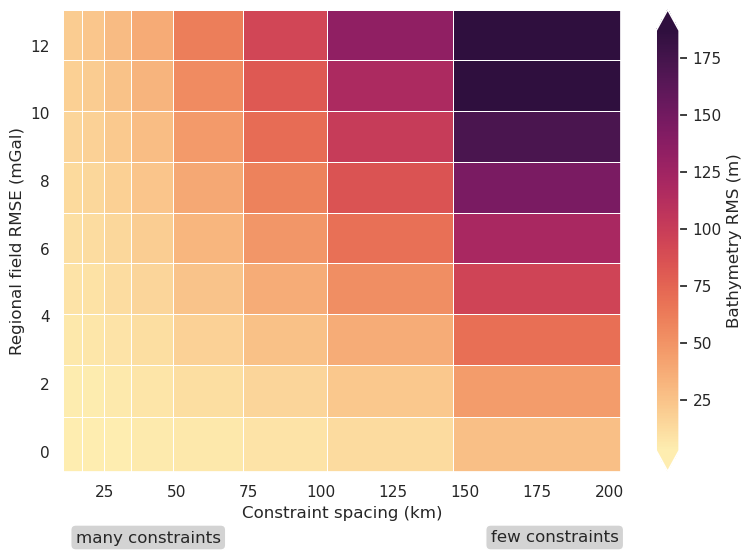

In [275]:
fig = RIS_plotting.plot_2var_ensemble(
    ensemble_df[ensemble_df.constraint_spacing_km < 300],
    x="constraint_spacing_km",
    y="regional_rmse",
    x_title="Constraint spacing (km)",
    y_title="Regional field RMSE (mGal)",
    background="rmse",
    background_title="Bathymetry RMS (m)",
    background_robust=True,

    # points_color="starting_topo_rmse",
    # points_label="starting topo RMSE",
    # points_share_cmap=True,

    # points_color="topo_improvement",
    # points_title="Topo improvement (m)",
    # points_lims=(0, ensemble_df.topo_improvement.max()),
    # points_robust=True,
    # points_size=40,
    # points_edgecolor=None,
)

# plt.hlines(-.02, xmin=0.35, xmax=.55, clip_on=False, color="black", linestyle="-", transform=plt.gcf().transFigure)
bbox = dict(facecolor='lightgray', boxstyle="round")
plt.gcf().text(0.3, -.0, "many constraints", fontsize=12, va="center", ha="right", bbox=bbox)
plt.gcf().text(0.6, -.0, "few constraints", fontsize=12, va="center", ha="left", bbox=bbox)

# Results
# expected relationship between constraint spacing, regional strength and inversion performance

# with lots of constraints, regional field is unimportant for inversion performance
# with few constraints, regional field is important for inversion performance
# with low regional field, constraints are unimportant for inversion performance
# with high regional field, constraints are important for inversion performance

# Discussion
# with low regional strength, no point in having more constraints
# with high regional strength, each additional constraint improves inversion performance

Text(0.6, -0.0, 'few constraints')

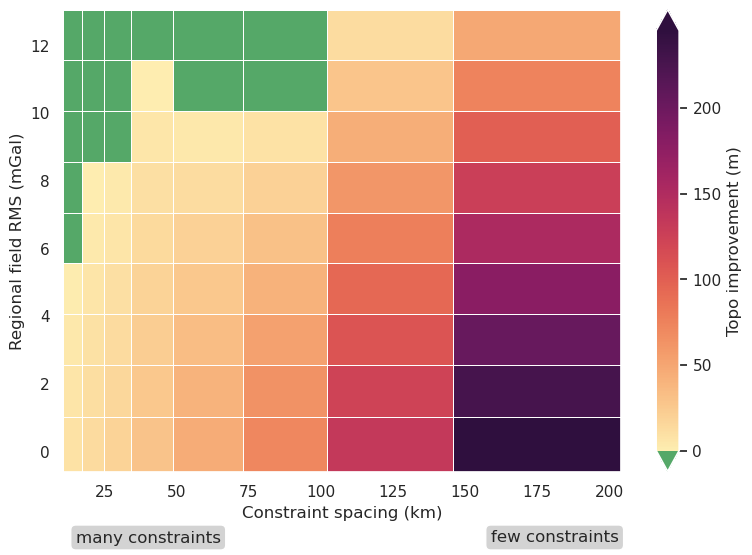

In [274]:
fig = RIS_plotting.plot_2var_ensemble(
    ensemble_df[ensemble_df.constraint_spacing_km < 300],
    x="constraint_spacing_km",
    y="regional_rmse",
    x_title="Constraint spacing (km)",
    y_title="Regional field RMS (mGal)",
    background="topo_improvement",
    background_title="Topo improvement (m)",
    background_robust=True,
    # background_cmap="cmo.balance",
    background_lims=(0, ensemble_df.topo_improvement.max()),

    # points_color="rmse",
    # points_title="Bathymetry RMSE (m)",
    # # points_lims=(0, ensemble_df.topo_improvement.max()),
    # points_robust=True,
    # points_size=40,
    # points_edgecolor=None,

    # plot_contours=[0],
)

# plt.hlines(-.02, xmin=0.35, xmax=.55, clip_on=False, color="black", linestyle="-", transform=plt.gcf().transFigure)
bbox = dict(facecolor='lightgray', boxstyle="round")
plt.gcf().text(0.3, -.0, "many constraints", fontsize=12, va="center", ha="right", bbox=bbox)
plt.gcf().text(0.6, -.0, "few constraints", fontsize=12, va="center", ha="left", bbox=bbox)

# Results
# expected relationship between constraint spacing, regional strength and topo improvement

# topo-improvement is highest for low regional strength and few constraints
# topo-improvement is generally low for high regional strength and many constraints
# for few constraints, inversion only useful for low regional strength
# for low regional strength, inversion only useful for few constraints


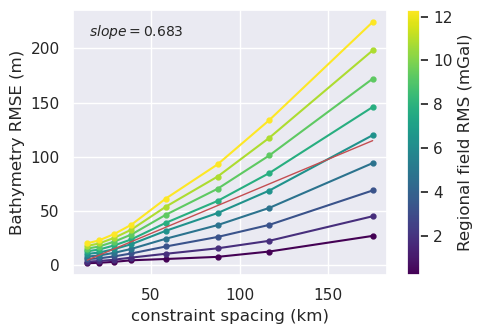

In [276]:
RIS_plotting.plot_ensemble_as_lines(
    ensemble_df[ensemble_df.constraint_spacing_km < 300],
    y="rmse",
    x="constraint_spacing_km",
    groupby_col="regional_rmse",
    x_label="constraint spacing (km)",
    cbar_label="Regional field RMS (mGal)",
    trend_line=True,
)
# Results
# for low regional strength, RMSE linearly dependent on constraint spacing
# for high regional strength, exponential relationship between RMSE and constraint spacing

# Discussion
# constraint spacing mostly important for high regional strengths

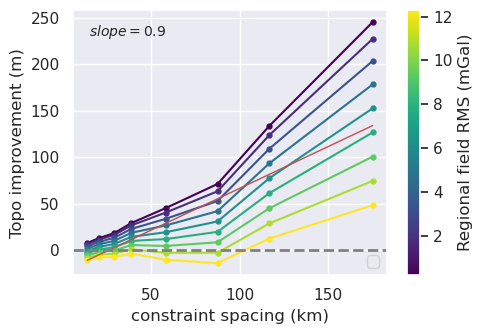

In [203]:
RIS_plotting.plot_ensemble_as_lines(
    ensemble_df[ensemble_df.constraint_spacing_km < 300],
    y="topo_improvement",
    x="constraint_spacing_km",
    groupby_col="regional_rmse",
    x_label="constraint spacing (km)",
    y_label="Topo improvement (m)",
    cbar_label="Regional field RMS (mGal)",
    trend_line=True,
    horizontal_line=0,
)
# Results
# for low regional strength, topo-improvement exponential related to constraint spacing
# for high regional strength, topo-improvement linearly related to constraint spacing

# Discussion
# for high regional strengths, having tighter than 100km constraint spacing offers no improvement
# for low regional strengths, continual improvement with more constraints

# with few constraints, inversion only offers improvement if high regional strength
# for high regional strengths, no point in doing inversion if lots of constraints
# for low regional strengths, regardless of constraint spacing, inversion offers improvement in topography
    # most improvement in topography for few constraints

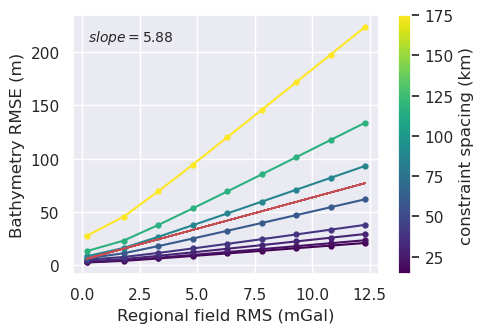

In [201]:
RIS_plotting.plot_ensemble_as_lines(
    ensemble_df[ensemble_df.constraint_spacing_km < 300],
    y="rmse",
    x="regional_rmse",
    groupby_col="constraint_spacing_km",
    x_label="Regional field RMS (mGal)",
    cbar_label="constraint spacing (km)",
    trend_line=True,
)
# Results
# performance linearly related to regional strength for all constraint spacings
# if lots of constraints, regional strength doesn't matter
# with constraint spacing > 100km, regional strength is very important
#

# Discussion
#


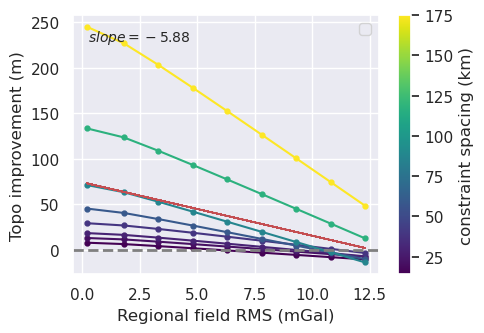

In [204]:
RIS_plotting.plot_ensemble_as_lines(
    ensemble_df[ensemble_df.constraint_spacing_km < 300],
    y="topo_improvement",
    x="regional_rmse",
    groupby_col="constraint_spacing_km",
    x_label="Regional field RMS (mGal)",
    y_label="Topo improvement (m)",
    cbar_label="constraint spacing (km)",
    trend_line=True,
    horizontal_line=0,
)
# Results
# for lots of constraints, topo-improvement doesn't change with any level of regional strength
# for low regional strengths, best topo-improvement with few constraints

# Discussion
#

In [286]:
ensemble_df.regional_strength.unique()

array([ 1.   ,  7.125, 13.25 , 19.375, 25.5  , 31.625, 37.75 , 43.875,
       50.   ])

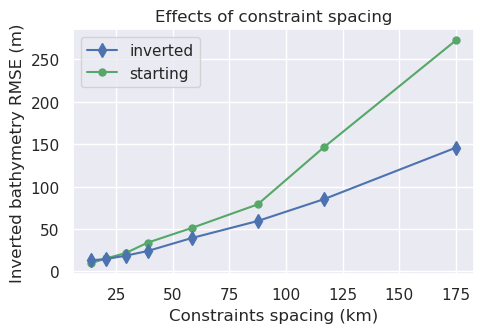

In [292]:
df = ensemble_df[ensemble_df.regional_strength==31.625]

RIS_plotting.plot_1var_ensemble(
    df=df[df.constraint_spacing_km < 300].rename(columns={"starting_topo_rmse": "starting_errors"}),
    x="constraint_spacing_km",
    y="rmse",
    title="Effects of constraint spacing",
    xlabel="Constraints spacing (km)",
    ylabel="Inverted bathymetry RMSE (m)",
    # horizontal_line=starting_rmse,
    # horizontal_line_label="Starting RMSE",
    plot_starting_error=True,
    # logx=True,
)